# Experiment A

# Hyperparameter Search Metrics:

1. Different projection dimensionality (Projection Dim)
- Idea: More dimensionality --> Better model training, higher dimensionality may cause overfitting
- Values: 1536, 768, 512, 256, 128, 64

- With higher dimensionality, we should achieve good results in both training and validation.
- Metrics: For each individual class, calculate AUC-PR, AUC-ROC, mean values of metrics per class

2. Same hyperparmaters as term paper (thesis)

## Part I: Loading Data & Dependencies

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy
import random
import ast
import zipfile
import cv2
import scipy.io as sio

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, precision_score, recall_score, f1_score, hamming_loss

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Use a fixed seed value
set_seed(42)

## Part II: Data

### Loading Data from pickle objects

In [3]:
def load_dataset(filename):
    """
    Load the ECGDataset object from a file.
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
single_batch_dataset = load_dataset("/content/single_batch_data.pkl")
mlb_classes = load_dataset("/content/mlb_classes.pkl")

In [5]:
len(single_batch_dataset)

256

In [ ]:
mlb_classes

### Create Dataloader Object

In [7]:
single_batch_loader = DataLoader(single_batch_dataset, batch_size=256, shuffle=True)

In [8]:
# Assuming `train_dataloader` is a DataLoader instance of your ECGDataset
for batch in single_batch_loader:
    ecgs = batch['ecg']  # Accessing the ECG data for the batch
    captions = batch['label']  # Accessing the labels (captions) for the batch

    print(f"ECG Shape: {ecgs.shape}")  # Printing the shape of the ECG tensor for the batch
    print(f"Label: {captions[0]}")  # Printing the label of the first sample in the batch
    print(f"Label Format:", type(captions[0]))  # Printing the type of the label

    # Break after the first batch for demonstration
    break

ECG Shape: torch.Size([256, 12, 5000])
Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
Label Format: <class 'torch.Tensor'>


## Part III: Image Encoder Model

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (x.size(-1) ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        output = torch.matmul(attention_weights, V)
        return output

In [10]:
class ECGEncoder1D(nn.Module):
    def __init__(self, num_classes=80):
        super(ECGEncoder1D, self).__init__()

        # 1D Convolutional layers
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, stride=2, padding=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=7, stride=2, padding=3)
        self.bn4 = nn.BatchNorm1d(256)

        self.attention = SelfAttention(256)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))

        # Apply attention
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, seq_len, channels)
        x = self.attention(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, channels, seq_len)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [11]:
model = ECGEncoder1D(num_classes=80)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ECGEncoder1D(
  (conv1): Conv1d(12, 32, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): SelfAttention(
    (query): Linear(in_features=256, out_features=256, bias=True)
    (key): Linear(in_features=256, out_features=256, bias=True)
    (value): Linear(in_features=256, out_features=256, bias=True)
  )
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=512, bias=T

In [12]:
print(model)

ECGEncoder1D(
  (conv1): Conv1d(12, 32, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): SelfAttention(
    (query): Linear(in_features=256, out_features=256, bias=True)
    (key): Linear(in_features=256, out_features=256, bias=True)
    (value): Linear(in_features=256, out_features=256, bias=True)
  )
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=512, bias=T

In [13]:
# Test the model with a sample input
sample_input = torch.randn(128, 12, 5000)  # [batch_size, channels, signal_length]
sample_input = sample_input.to(device)  # Move input tensor to the same device as the model
output = model(sample_input)
print("Output shape:", output.shape)

Output shape: torch.Size([128, 80])


#### Model Training

In [14]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = Adam(model.parameters(), lr=0.005, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=10, verbose=True)

# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Epoch', 'Class', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC-ROC', 'Hamming Loss'])
class_names = mlb_classes

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


**Debugging**:

- Train model on one batch and try to overfit. The F1-score, AUC-ROC should be close to 1 if the model is overfitting.
- For evaluation metrics, calculate them manually instead of with sklearn's functions.

In [ ]:
# num_epochs = 20
# best_val_loss = float('inf')

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0

#     for batch in single_batch_loader:
#         inputs, labels = batch['ecg'].to(device).float(), batch['label'].to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         train_loss += loss.item() * inputs.size(0)

#     # Evaluation on the same batch
#     model.eval()
#     with torch.no_grad():
#         outputs = model(inputs)
#         val_loss = criterion(outputs, labels).item()

#     # Convert outputs to predictions
#     preds = torch.sigmoid(outputs).cpu().numpy()
#     preds_binary = (preds > 0.5).astype(int)
#     true_labels = labels.cpu().numpy()

#     # Calculate metrics manually for each class
#     epoch_metrics = []
#     for i, class_name in enumerate(class_names):
#         TP = np.sum((preds_binary[:, i] == 1) & (true_labels[:, i] == 1))
#         TN = np.sum((preds_binary[:, i] == 0) & (true_labels[:, i] == 0))
#         FP = np.sum((preds_binary[:, i] == 1) & (true_labels[:, i] == 0))
#         FN = np.sum((preds_binary[:, i] == 0) & (true_labels[:, i] == 1))

#         # Calculate metrics
#         accuracy = (TP + TN) / (TP + TN + FP + FN)
#         precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#         recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#         f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#         # AUC-ROC
#         if len(np.unique(true_labels[:, i])) > 1:
#             auc_roc = roc_auc_score(true_labels[:, i], preds[:, i])
#         else:
#             auc_roc = np.nan

#         # Hamming loss
#         hamming = np.mean(preds_binary[:, i] != true_labels[:, i])

#         epoch_metrics.append({
#             'Epoch': epoch+1,
#             'Class': class_name,
#             'Accuracy': accuracy,
#             'F1-Score': f1,
#             'Precision': precision,
#             'Recall': recall,
#             'AUC-ROC': auc_roc,
#             'Hamming Loss': hamming
#         })

#     epoch_df = pd.DataFrame(epoch_metrics)
#     metrics_df = pd.concat([metrics_df, epoch_df], ignore_index=True)

#     # Calculate average loss
#     avg_train_loss = train_loss / len(single_batch_dataset)

#     # Update learning rate
#     scheduler.step(val_loss)

#     # Save best model
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')

#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
#     print(f"Epoch {epoch+1}/{num_epochs} metrics appended to DataFrame")

In [15]:
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in single_batch_loader:
        inputs, labels = batch['ecg'].to(device).float(), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Evaluation on the same batch
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        val_loss = criterion(outputs, labels).item()

    # Convert outputs to predictions
    preds = torch.sigmoid(outputs).cpu().numpy()
    preds_binary = (preds > 0.5).astype(int)
    true_labels = labels.cpu().numpy()

    # Calculate metrics manually for each class
    epoch_metrics = []
    for i, class_name in enumerate(class_names):
        TP = np.sum((preds_binary[:, i] == 1) & (true_labels[:, i] == 1))
        TN = np.sum((preds_binary[:, i] == 0) & (true_labels[:, i] == 0))
        FP = np.sum((preds_binary[:, i] == 1) & (true_labels[:, i] == 0))
        FN = np.sum((preds_binary[:, i] == 0) & (true_labels[:, i] == 1))

        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # AUC-ROC
        if len(np.unique(true_labels[:, i])) > 1:
            auc_roc = roc_auc_score(true_labels[:, i], preds[:, i])
        else:
            auc_roc = np.nan

        # Hamming loss
        hamming = np.mean(preds_binary[:, i] != true_labels[:, i])

        epoch_metrics.append({
            'Epoch': epoch+1,
            'Class': class_name,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall,
            'AUC-ROC': auc_roc,
            'Hamming Loss': hamming,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN
        })

    epoch_df = pd.DataFrame(epoch_metrics)
    metrics_df = pd.concat([metrics_df, epoch_df], ignore_index=True)

    # Calculate average loss
    avg_train_loss = train_loss / len(single_batch_dataset)

    # Update learning rate
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} metrics appended to DataFrame")

    # Print some example metrics for a few classes
    print("\nExample metrics for a few classes:")
    for i in range(min(5, len(class_names))):
        print(f"{class_names[i]}:")
        print(f"  TP: {epoch_metrics[i]['TP']}, TN: {epoch_metrics[i]['TN']}, FP: {epoch_metrics[i]['FP']}, FN: {epoch_metrics[i]['FN']}")
        print(f"  Accuracy: {epoch_metrics[i]['Accuracy']:.4f}, F1-Score: {epoch_metrics[i]['F1-Score']:.4f}")

Epoch 1/50, Train Loss: 0.6909, Validation Loss: 0.2615
Epoch 1/50 metrics appended to DataFrame

Example metrics for a few classes:
1st degree av block:
  TP: 0, TN: 251, FP: 0, FN: 5
  Accuracy: 0.9805, F1-Score: 0.0000
2nd degree av block:
  TP: 0, TN: 256, FP: 0, FN: 0
  Accuracy: 1.0000, F1-Score: 0.0000
accelerated atrial escape rhythm:
  TP: 0, TN: 256, FP: 0, FN: 0
  Accuracy: 1.0000, F1-Score: 0.0000
accelerated idioventricular rhythm:
  TP: 0, TN: 256, FP: 0, FN: 0
  Accuracy: 1.0000, F1-Score: 0.0000
accelerated junctional rhythm:
  TP: 0, TN: 256, FP: 0, FN: 0
  Accuracy: 1.0000, F1-Score: 0.0000
Epoch 2/50, Train Loss: 0.4965, Validation Loss: 0.2509
Epoch 2/50 metrics appended to DataFrame

Example metrics for a few classes:
1st degree av block:
  TP: 0, TN: 251, FP: 0, FN: 5
  Accuracy: 0.9805, F1-Score: 0.0000
2nd degree av block:
  TP: 0, TN: 256, FP: 0, FN: 0
  Accuracy: 1.0000, F1-Score: 0.0000
accelerated atrial escape rhythm:
  TP: 0, TN: 256, FP: 0, FN: 0
  Accura

In [16]:
metrics_df.to_csv("metrics.csv")

- **True Positive (TP)**: The model correctly predicts the positive class.
- **True Negative (TN)**: The model correctly predicts the negative class.
- **False Positive (FP)**: The model incorrectly predicts the positive class when it’s actually negative.
- **Negative (FN)**: The model incorrectly predicts the negative class when it’s actually positive.


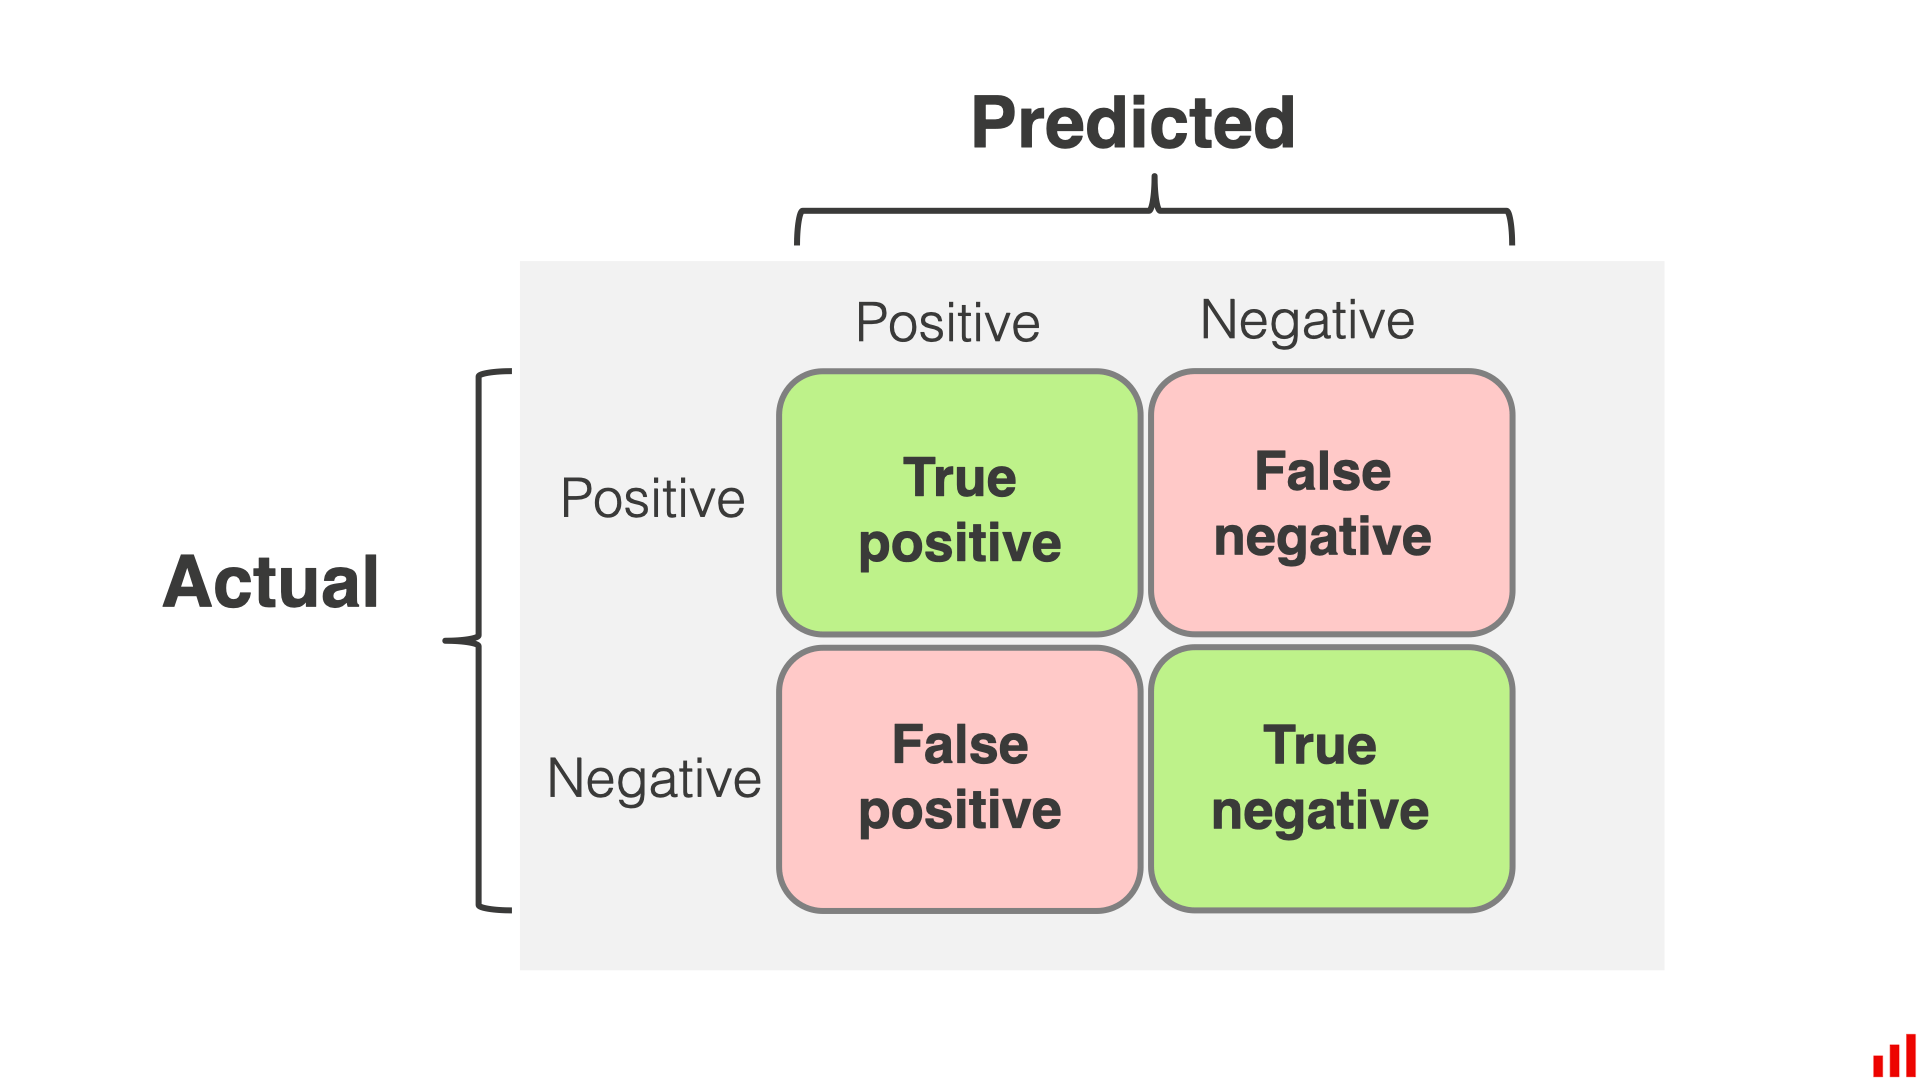